## ВКР: анализ данных

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

В данном ноутбуке предобработанные в ноутбуке `preprocessing.ipynb` данные мы будем анализировать и делать из них полезные для принятия HR-решений выводы.

### Библиотеки

Импорт библиотек:

In [254]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

Мы имеем таблицу с данными, в которых все признаки приведены к простому виду, выделены новые полезные признаки, была произведена суммаризация раздела "О себе". Теперь мы произведем токенизацию раздела "О себе" на совокупность 3-грамм, которые мы и будем считать токенами, после чего построим эмбеддинги.

**Токенизация раздела "О себе" на 1-граммы:**

In [120]:
df = pd.read_csv('resumes_features.csv')

In [122]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [124]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,"О себе, avg_tokens","О себе, 3-grams",Где работал,Где работал?,Аналитические комбинации слов,DA,DS,Кол-во работ,Аналитические комбинации слов в работе,Аналитические комбинации слов в навыках
2639,https://hh.ru/resume/4a310d020002587a310039ed1...,Руководитель отдела продаж,"Москва, м. Профсоюзная, не готов к переезду, н...",Опыт работы 5 лет 6 месяцев,Проходил обучение на корпоративных тренингах: ...,Высшее образование\n2011\nПрофессиональный инс...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Профессиональный институт юриспруденции,NaN,...,0.000216,"['проходить обучение корпоративный', 'обучение...","['Media Markt и Saturn', 'Media Markt и Saturn...","['Media Markt и Saturn', 'Media Markt и Saturn...",---,NaN,NaN,83,---,---


Для начала построим разбиение на 1-граммы (в коде также мы уберем пробелы и ненужные символы, стоп-слова, приведем слова к нормальной форме):

In [125]:
import nltk
# nltk.download('stopwords')

import re
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
patterns = "[0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    # print(doc)
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru and morph.normal_forms(token)[0] not in stopwords_ru:  # ВОТ откуда там стоп-слвоа — В not in stopwords_ru -> normal(В) = в
            # print(token)
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
    if len(tokens) > 2:
        return tokens
    return None

df2 = pd.DataFrame(df['О себе, summarized'])

for col_ind in df2.index:
    col = df2.loc[col_ind]['О себе, summarized']
    if col:
        df2.loc[col_ind]['О себе, summarized'] = lemmatize(str(col))
        #print(lemmatize(str(col)))
        
data = df2['О себе, summarized']

from collections import defaultdict
word_freq = defaultdict(int)
for tokens in data.iloc[:]:
    if tokens:
        for token in tokens:
            word_freq[token] += 1

Видим, что разбиение прошло успещно:

In [126]:
df2.sample(3)

,"О себе, summarized"
2523,"[трудолюбивый, трудолюбивый, легко, обучать, с..."
1893,"[постоянно, активно, развиваться, интернет, ма..."
2618,None


Теперь построим 2-граммы по 1-граммам:

In [127]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens2 = []

for x in df2['О себе, summarized']:
    if x is not None:
        bigrams = []
        for bg in list(ngrams(x, 2)):
            bigrams.append(' '.join(bg))
        tokens2.append(bigrams)
    else:
        tokens2.append(None)
        
df2['О себе 2'] = tokens2

In [128]:
df2.sample(3)

,"О себе, summarized",О себе 2
853,"[уверенный, черта, характер, стрессоустойчивос...","[уверенный черта, черта характер, характер стр..."
54,"[английский, язык, –, upper, intermediate, про...","[английский язык, язык –, – upper, upper inter..."
2565,"[форвард, сборная, россия, хоккей, евгений, ма...","[форвард сборная, сборная россия, россия хокке..."


Аналогичным образом, наконец, построим 3-граммы:

In [129]:
from nltk.util import ngrams
from nltk import word_tokenize 

tokens3 = []

for x in df2['О себе, summarized']:
    if x is not None:
        trigrams = []
        for tg in list(ngrams(x, 3)):
            trigrams.append(' '.join(tg))
        tokens3.append(trigrams)
    else:
        tokens3.append(None)
        
df2['О себе 3'] = tokens3

In [130]:
df2.sample(3)

,"О себе, summarized",О себе 2,О себе 3
640,"[germany, россия, сша, канада, австралия, арге...","[germany россия, россия сша, сша канада, канад...","[germany россия сша, россия сша канада, сша ка..."
152,None,None,None
806,"[обладать, доминировать, эмпатия, целеустремлё...","[обладать доминировать, доминировать эмпатия, ...","[обладать доминировать эмпатия, доминировать э..."


**Построение эмбеддингов**

Теперь перейдем к построению эмбеддингов. Будем использовать метод построения эмбеддингов word2vec. Определим векторное представление триграммы как среднее векторных представлений слов внутри нее.

In [131]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

Избавимся от пропусков, чтобы не было проблем с применением метода:

In [132]:
df2.loc[df2['О себе 3'].isna(), 'О себе 3'] = '-'

In [133]:
df2[df2['О себе 3'].isna()]['О себе 3']

Series([], Name: О себе 3, dtype: object)

Обучим модель:

In [134]:
model = Word2Vec(sentences=df2['О себе 3'], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [135]:
model = Word2Vec.load("word2vec.model")

In [136]:
model.train(df2['О себе 3'], total_examples=len(df2['О себе 3']), epochs=1)

(41868, 42180)

Посмотрим, что получилось, на примере:

In [142]:
vector = model.wv['нестандартный подход решение']  # get numpy vector of a word
sims = model.wv.most_similar('нестандартный подход решение', topn=10)  # get other similar words

In [19]:
vector

array([ 2.2067500e-03, -7.3231361e-03,  7.8011141e-03,  7.6452661e-03,
        2.4990677e-03, -6.3624647e-03, -5.9403661e-05,  3.4782612e-03,
       -5.6626188e-04,  5.9506493e-03, -3.4510384e-03,  4.3406021e-03,
       -3.4173462e-03,  4.9557914e-03,  7.2136098e-03, -7.3125749e-03,
       -6.6994298e-03,  9.5764669e-03,  2.1601473e-03, -6.2942142e-03,
       -1.8191544e-03, -3.3437440e-03,  6.3336780e-04,  2.4854629e-03,
        6.5179047e-04, -2.0766382e-03,  1.5287504e-03,  7.1112881e-03,
        7.1763177e-03, -2.8673734e-03, -9.1822697e-03,  6.9630803e-03,
        2.2413163e-03,  2.8338658e-03,  3.1316516e-03,  6.2846639e-03,
       -7.1329245e-04,  4.0908363e-03, -7.2425319e-05, -9.3654795e-03,
       -2.0878434e-03, -7.2188018e-04, -7.2491588e-04,  5.9062704e-03,
       -7.4123605e-03,  9.8371506e-03, -5.1827966e-03,  2.8906062e-03,
        4.1390378e-03,  7.8106583e-03, -1.1367421e-03, -5.6662778e-03,
        9.1947811e-03, -7.3702243e-04, -5.4288865e-03,  2.2407942e-03,
      

In [143]:
sims

[('ум способность работать', 0.42437753081321716),
 ('крупный российский агентство', 0.41329023241996765),
 ('подготовка рисовый руководство', 0.38147082924842834),
 ('письменный речь быстрый', 0.3720853924751282),
 ('человек направление проектирование', 0.3675800859928131),
 ('опыт управление опыт', 0.3589397966861725),
 ('строить bi дашборд', 0.34726792573928833),
 ('эффективный проектный группа', 0.3456355929374695),
 ('футбольный болельщик готовиться', 0.3422141373157501),
 ('дважды выигрывать золото', 0.34142419695854187)]

Вектор построен корректно, похожие триграммы подобраны неплохо с точки зрения соответствия смыслу.

Итак, мы построили эмбеддинги. Теперь создадим табличку, где каждому резюме будет соответстовать вектор из 100 координат входящих в раздел "О себе" триграмм.

In [148]:
our_data = pd.DataFrame(df2['О себе 3'])
our_data['emb'] = 0
embs = []
for x in our_data['О себе 3']:
    cur_embs = []
    for y in x:
        cur_embs.append(model.wv[y])
    embs.append(cur_embs)
our_data['emb'] = embs

embs_flattened = []
for x in our_data['emb']:
    x_flat = np.array(x[0])
    for z in x[1:]:
        x_flat += np.array(z)
    embs_flattened.append(x_flat / len(x))
our_data['flat_emb'] = embs_flattened

Посмотрим, получилось ли:

In [150]:
our_data['flat_emb'][0]

array([-7.99836344e-05, -1.50046463e-03, -4.35551920e-04, -1.50737166e-03,
        1.87101890e-04, -6.84491824e-04, -1.10338395e-03,  2.63537018e-04,
        9.67469008e-04,  8.15248408e-04, -4.59374889e-04,  1.31592283e-03,
        2.90577824e-04,  5.82164037e-04, -1.85195502e-04, -3.72505398e-04,
       -9.81115038e-04, -8.18226545e-04,  8.66354312e-05,  3.16900783e-04,
        1.21780892e-03, -1.17878360e-03, -4.52461682e-05, -2.16449465e-04,
        2.96607963e-04, -2.84905545e-04, -4.40094824e-04, -6.48278743e-04,
       -2.86327646e-04,  1.69932446e-03,  4.80593997e-04, -1.15398632e-03,
        8.43726564e-04, -1.05837127e-03,  4.97588073e-04,  4.34242276e-04,
        2.84139242e-04, -5.80462860e-04, -1.16366755e-04, -1.56020408e-03,
       -2.40851557e-04, -7.77751848e-04, -7.10505934e-04,  2.73809914e-04,
        5.04683412e-04, -1.38456665e-03,  1.26650848e-03,  9.75667150e-04,
       -6.85438747e-04,  1.60656040e-04, -1.13937957e-03,  3.06473696e-04,
       -4.63332981e-07, -

Действительно, получился вектор из $\mathbb{R}^{100}$, где $i$-я координата — среднее эмбеддингов входящих в $i$-ю триграмму слов.

Уберем пропуски и запишем в `X` наши векторы:

In [213]:
our_data['flat_emb'].dropna()
X = list(our_data['flat_emb'].dropna())
X = np.asarray(X)
X

array([[-7.9983634e-05, -1.5004646e-03, -4.3555192e-04, ...,
        -4.4411735e-04,  7.6554163e-04,  8.0740218e-05],
       [ 6.5256917e-04, -1.3126576e-03, -7.2877301e-05, ...,
        -2.4316886e-04, -3.1289060e-03,  1.4584048e-03],
       [-1.3510333e-04,  8.5367518e-04,  2.2937981e-03, ...,
        -2.7531173e-04, -3.1162152e-04, -4.3715845e-04],
       ...,
       [ 2.5283226e-03,  2.1679702e-03,  4.1107135e-03, ...,
         2.6390133e-03, -1.6444033e-03, -3.4496421e-05],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03],
       [-5.3622725e-04,  2.3643016e-04,  5.1033497e-03, ...,
        -7.0415614e-03,  9.0145587e-04,  6.3925339e-03]], dtype=float32)

Осталось проверить, правда ли имеющие близкое к 0 [cosine distance](https://medium.com/geekculture/cosine-similarity-and-cosine-distance-48eed889a5c4) векторы похожи, а близкое к 1 — различны.

Пример ортогональных векторов:

In [82]:
df['О себе, summarized'][0]

'Уверенный пользователь ПК, Ms Word, Ms Excel, 1С, Power Point, Internet Explorer, amoCRM, Bitrix24 и офисной техники; Правовых систем Гарант и Консультант +; Знание законодательства; Работа с входящей и исходящей корреспонденцией, Этика делового общения, общения с клиентами; Навыки работы по взаимодействию с государственными органами и общественными организациями; Неоднократное участие в судебных заседаниях; Анализ данных, составление договоров, запросов, отзывов, заявлений, уведомлений.'

In [83]:
df['О себе, summarized'][1]

'В настоящее время занимаюсь благотворительной деятельностью. В свободное время занимаюсь бегом, плаванием, рисую в стиле фантази (карандаш), много путешествую, интересуюсь различиями культур и обычаями народов мира.'

In [119]:
distance.cosine(X[0], X[1])

0.9508250653743744

Действительно, мы вижим, что резбме различны.

Пример коллинеарных:

In [87]:
df['О себе, summarized'][14]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет официального места работы.'

In [88]:
df['О себе, summarized'][84]

'Нахожусь в отпуске по уходу за ребенком. На данный момент у меня нет вакантных должностей.'

In [118]:
distance.cosine(X[14], X[84])

0.30464255809783936

Видно, что резюме похожи. 

Осталось записать эти векторы в 100 столбцов нашей таблицы:

In [234]:
for col in list(pd.DataFrame(X)):
    df[str(col)] = pd.DataFrame(X)[col]

In [237]:
df.sample(2)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,90,91,92,93,94,95,96,97,98,99
121,https://hh.ru/resume/043d1db90003ba62800039ed1...,Менеджер / руководитель банка по работе с корп...,"Москва, готова к переезду, готова к командировкам",Опыт работы 23 года 4 месяца,Достижения:\nВ роли клиентского менеджера неод...,Высшее образование\n2000\nВоронежский государс...,Специализации:\nМенеджер/консультант по страте...,Проектное управление\nРабота в команде\nОргани...,Воронежский государственный аграрный университ...,Воронежский государственный аграрный университ...,...,0.000286,0.000614,0.001554,-0.002824,0.000827,0.000280,0.001855,-0.001364,-0.001045,-0.001283
1637,https://hh.ru/resume/14e87dbf0000728a8a0039ed1...,эксперт по бизнес-процессам (управленческий/ин...,"Москва, не готов к переезду, не готов к команд...",Опыт работы 19 лет 10 месяцев,"Компетенции, навыки, знания, умения:\n• Владен...",Высшее образование\n2002\nМИРЭА\nавтоматизиров...,Специализации:\nРуководитель группы разработки...,---,МИРЭА,NaN,...,0.000520,0.001356,-0.001179,-0.000428,-0.000851,-0.000229,0.003184,0.001581,0.000368,-0.000344


Сохраним то, что получилось:

In [275]:
df.to_csv('resumes_features.csv')

**Модель**

Наконец, перейдем к построению скоринговой модели (решим задачу классификации):

In [120]:
df = pd.read_csv('resumes_features.csv')

In [122]:
df.drop(list(df)[0], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop(list(df)[0], axis=1, inplace=True)

In [124]:
df.sample(1)

,Ссылка,Название,Коммандировка,Опыт,О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,...,"О себе, avg_tokens","О себе, 3-grams",Где работал,Где работал?,Аналитические комбинации слов,DA,DS,Кол-во работ,Аналитические комбинации слов в работе,Аналитические комбинации слов в навыках
2639,https://hh.ru/resume/4a310d020002587a310039ed1...,Руководитель отдела продаж,"Москва, м. Профсоюзная, не готов к переезду, н...",Опыт работы 5 лет 6 месяцев,Проходил обучение на корпоративных тренингах: ...,Высшее образование\n2011\nПрофессиональный инс...,Специализации:\nРуководитель отдела продаж\nЗа...,---,Профессиональный институт юриспруденции,NaN,...,0.000216,"['проходить обучение корпоративный', 'обучение...","['Media Markt и Saturn', 'Media Markt и Saturn...","['Media Markt и Saturn', 'Media Markt и Saturn...",---,NaN,NaN,83,---,---


Зададим множества:

In [298]:
X = df.loc[df['DA'].notna()].loc[:, list(df)[36:]]

In [299]:
y = df.loc[df['DA'].notna(), 'DA']

Обучаем модель:

In [292]:
from sklearn.linear_model import LogisticRegression

In [293]:
reg = LogisticRegression()

In [327]:
X_train = X.sample(95)
y_train = y[X_train.index]

In [328]:
X_test = X.drop(X_train.index)
y_test = y.drop(y_train.index)

In [329]:
reg.fit(X_train, y_train)

LogisticRegression()

Смотрим на accuracy:

In [330]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, reg.predict(X_test))

0.4

Какие еще добавить признаки:

!! Проблема с Опытом + OHE

In [342]:
df.loc[:,['Кол-во образований',
'Топовость образования',
'Справочник по интересам',
'Релокация?',
'Коммандировка?',
'Город?',
'Опыт нормализованный',
'Уровень оборазования нормализованный',
'Карьерный рост',
'Аналитические комбинации слов в навыках']]

,Кол-во образований,Топовость образования,Справочник по интересам,Релокация?,Коммандировка?,Город?,Опыт нормализованный,Уровень оборазования нормализованный,Карьерный рост,Аналитические комбинации слов в навыках
0,2,False,---,готова к редким командировкам,не готова к переезду,Москва,---,Высшее образование,False,found smt by rule (SQL)|(Excel)|(Python)|(Tabl...
1,1,False,---,готова к командировкам,готова к переезду,Москва,---,Высшее образование,False,---
2,1,False,---,готова к командировкам,готова к переезду,Шахты,---,Высшее образование,False,---
3,2,False,---,готов к командировкам,готов к переезду,Москва,---,Высшее образование,True,---
4,1,False,---,готов к командировкам,готов к переезду,Краснодар,---,Среднее специальное образование,True,---
...,...,...,...,...,...,...,...,...,...,...
2720,1,False,found smt by rule (Analyst)|(Аналитик данных)|...,не готова к командировкам,не готова к переезду,Москва,---,Высшее образование,True,---
2721,1,False,found smt by rule (Analyst)|(Аналитик данных)|...,готов к командировкам,не готов к переезду,Москва,---,Неоконченное высшее образование,True,---
2722,1,False,---,готова к командировкам,не готова к переезду,Москва,---,Высшее образование,True,---
2723,2,False,---,готов к командировкам,готов к переезду,Москва,---,Высшее образование,False,---


**Кластеризация**

In [249]:
scaler = StandardScaler()
x = scaler.fit_transform(df.loc[:, list(df)[36:]])

In [250]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [251]:
pca.explained_variance_ratio_[:2].sum()

0.6274043196127124

In [252]:
principal.sample(2)

,principal component 1,principal component 2,principal component 3
1749,-3.773290,-1.913587,5.934628
1607,-0.641084,-3.289873,0.036668


/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='principal component 1', ylabel='principal component 2'>

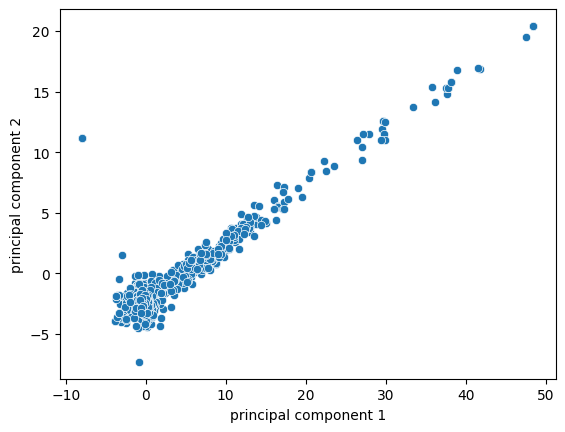

In [255]:
sns.scatterplot(principal['principal component 1'], principal['principal component 2'])

In [256]:
kmeans = KMeans(n_clusters=4).fit(principal)
l = kmeans.labels_

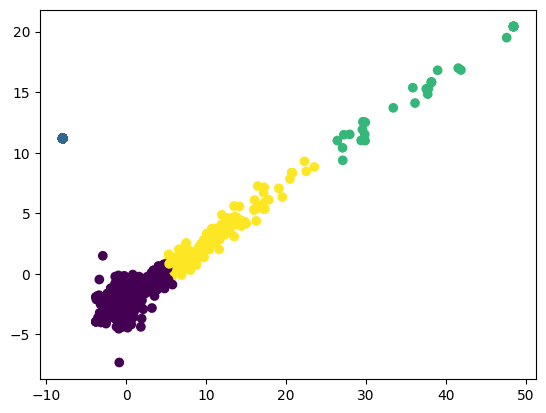

In [257]:
plt.scatter(principal['principal component 1'], 
             principal['principal component 2'],
             c=l,
           )

In [155]:
df.loc[df['clust']==0]['О себе']

0       Уверенный пользователь ПК, Ms Word, Ms Excel, ...
1       Энергична, активна, в поиске новых возможносте...
2       опыт прямых продаж, ведение коммерческих перег...
3       Коммуникабелен\nУмение работать с возражениями...
4       Дисциплина - умение выполнять поставленные зад...
                              ...                        
2988    Опыт управления более 15-и лет. Развитые управ...
2990    Аналитика продаж ,поиск клиентов,связь с произ...
2994    Многозадачность, стрессоустойчивость, инициати...
2995    Уверенный пользователь ПК: MS Office (Word, Ex...
2997                                                    .
Name: О себе, Length: 2057, dtype: object

In [184]:
for x in np.unique(df['clust']):
    print(x + 1, ':', df.loc[df['clust']==x]['О себе'].shape[0])

1 : 2057
2 : 356
3 : 27
4 : 25
5 : 80
6 : 41
7 : 139
